# Principal Component Analysis (PCA)

## Introduction

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a dataset with potentially correlated features into a set of linearly uncorrelated variables called principal components. The transformation is defined in such a way that the first principal component captures the largest possible variance in the data, and each succeeding component has the highest variance possible under the constraint that it is orthogonal to the preceding components.

### Mathematical Principles

PCA works through the following steps:

1. **Standardization**: Center the data by subtracting the mean of each feature, and optionally scale it by dividing by the standard deviation.

2. **Covariance Matrix Computation**: Calculate the covariance matrix of the standardized data.
   $$\Sigma = \frac{1}{n-1} X^T X$$
   where $X$ is the standardized data matrix and $n$ is the number of samples.

3. **Eigendecomposition**: Compute the eigenvectors and eigenvalues of the covariance matrix.
   $$\Sigma v = \lambda v$$
   where $v$ is an eigenvector and $\lambda$ is the corresponding eigenvalue.

4. **Principal Components**: The eigenvectors represent the principal components, and the eigenvalues represent the amount of variance explained by each principal component.

5. **Dimensionality Reduction**: Select the top $k$ eigenvectors (those with the largest eigenvalues) to form a new basis for the data, reducing the dimensionality from $p$ to $k$.

6. **Transformation**: Project the data onto the new basis to obtain the transformed dataset.
   $$Z = X W$$
   where $W$ is the matrix of selected eigenvectors.

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import time
import warnings
from matplotlib.colors import ListedColormap

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the digits dataset
digits = load_digits()

# Create a pandas DataFrame for easier manipulation
X = digits.data
y = digits.target
feature_names = [f'pixel_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(X, columns=feature_names)
data['target'] = y

# Display basic dataset information
print(f"Dataset shape: {data.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Sample per class: {np.bincount(y)}")

# Display the first few rows of the dataset
data.head()

Dataset shape: (1797, 65)
Number of features: 64
Number of samples: 1797
Number of classes: 10
Sample per class: [178 182 177 183 181 182 181 179 174 180]


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Basic statistical summary
data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
pixel_0,1797.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
pixel_1,1797.0,0.303840,0.907192,0.0,0.0,0.0,0.0,8.0
pixel_2,1797.0,5.204786,4.754826,0.0,1.0,4.0,9.0,16.0
pixel_3,1797.0,11.835838,4.248842,0.0,10.0,13.0,15.0,16.0
pixel_4,1797.0,11.848080,4.287388,0.0,10.0,13.0,15.0,16.0


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
print(f"Total missing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])

Missing values per column:
Total missing values: 0


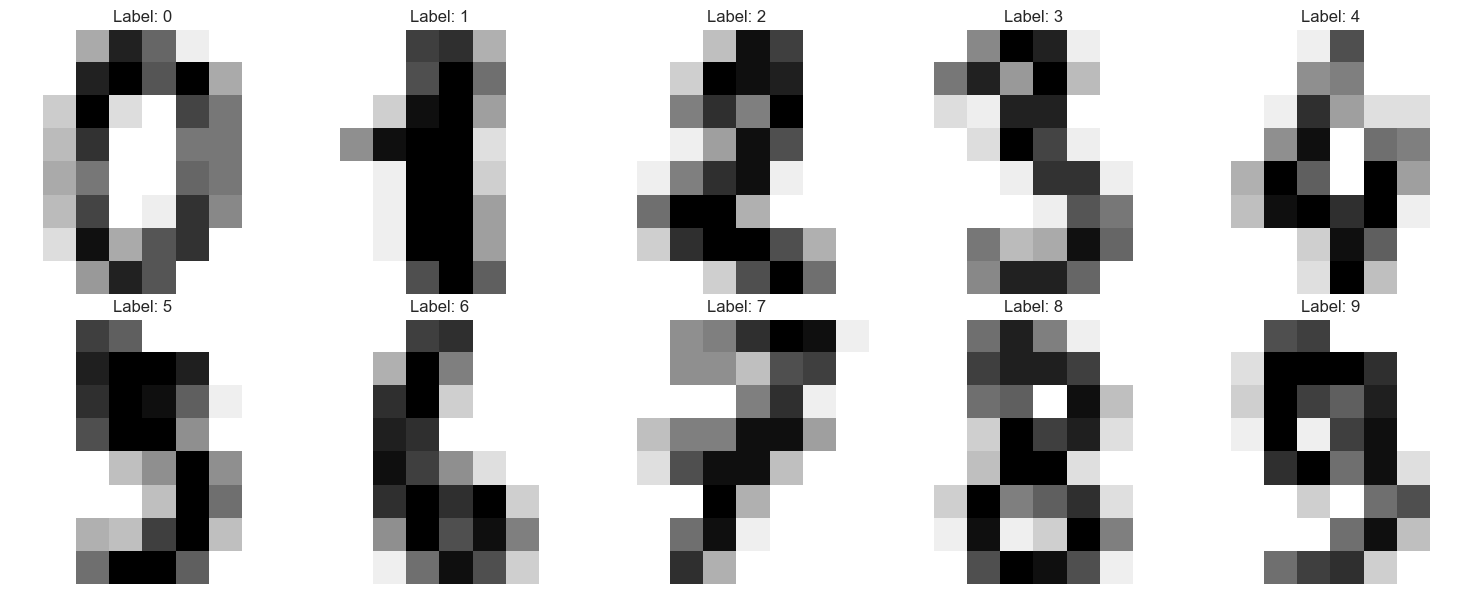

In [5]:
# Visualize some sample digits
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='binary')
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

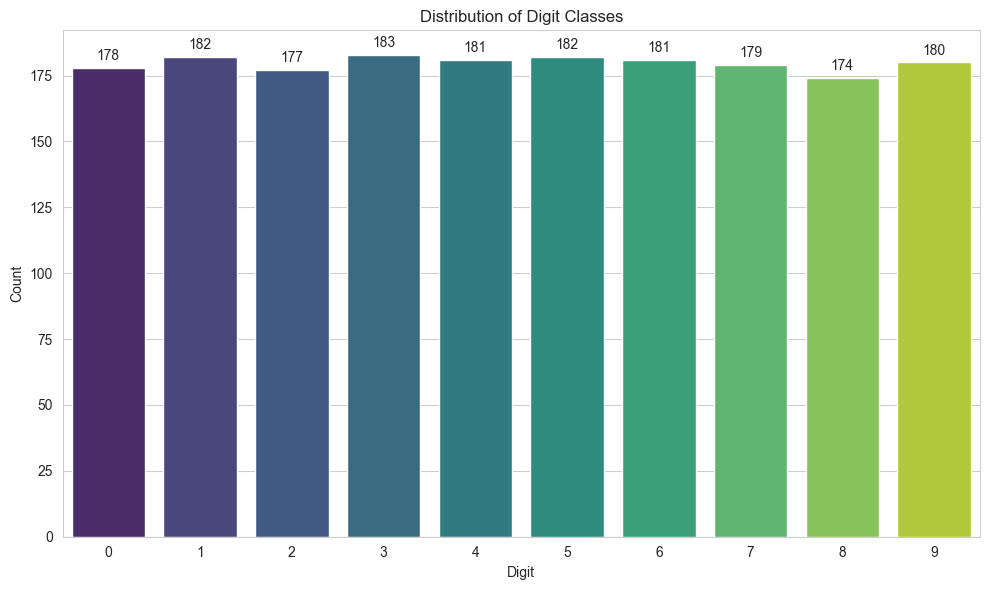

In [6]:
# Distribution of target classes
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=data, palette='viridis')
plt.title('Distribution of Digit Classes')
plt.xlabel('Digit')
plt.ylabel('Count')
for i, count in enumerate(np.bincount(y)):
    plt.text(i, count + 3, str(count), ha='center')
plt.tight_layout()
plt.show()

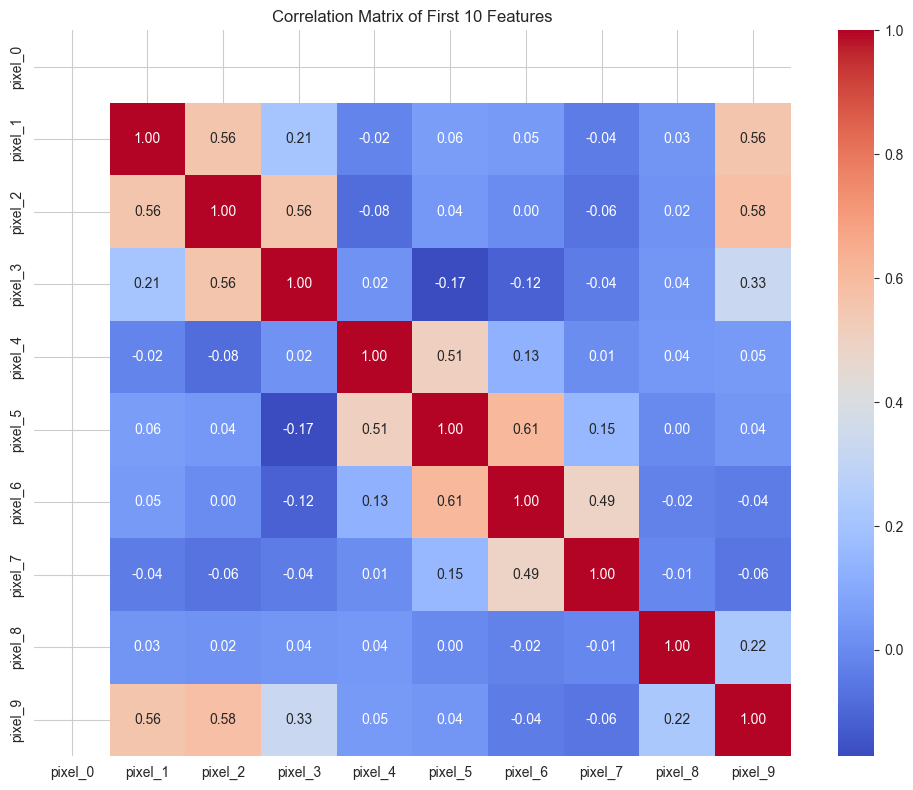

In [7]:
# Calculate correlation matrix for the first 10 features
correlation_matrix = data[feature_names[:10]].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set shape: (1347, 64)
Testing set shape: (450, 64)
Training set class distribution: [133 136 133 137 136 136 136 134 131 135]
Testing set class distribution: [45 46 44 46 45 46 45 45 43 45]


In [9]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Check the mean and standard deviation of the scaled data
print("Mean of scaled training data:", X_train_scaled.mean(axis=0)[:5], "...")
print("Standard deviation of scaled training data:", X_train_scaled.std(axis=0)[:5], "...")

Mean of scaled training data: [ 0.00000000e+00 -8.43176061e-17  8.16801052e-17 -2.03252411e-16
  1.10816248e-16] ...
Standard deviation of scaled training data: [0. 1. 1. 1. 1.] ...


## 4. Implementing PCA

In [10]:
# Apply PCA without specifying the number of components
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Display the explained variance
print("Explained variance by each principal component:")
for i, var in enumerate(explained_variance_ratio[:10]):
    print(f"PC{i+1}: {var:.4f} ({cumulative_explained_variance[i]:.4f} cumulative)")
print("...")

Explained variance by each principal component:
PC1: 0.1192 (0.1192 cumulative)
PC2: 0.0967 (0.2159 cumulative)
PC3: 0.0834 (0.2993 cumulative)
PC4: 0.0670 (0.3663 cumulative)
PC5: 0.0485 (0.4148 cumulative)
PC6: 0.0446 (0.4594 cumulative)
PC7: 0.0392 (0.4986 cumulative)
PC8: 0.0335 (0.5321 cumulative)
PC9: 0.0298 (0.5619 cumulative)
PC10: 0.0290 (0.5910 cumulative)
...


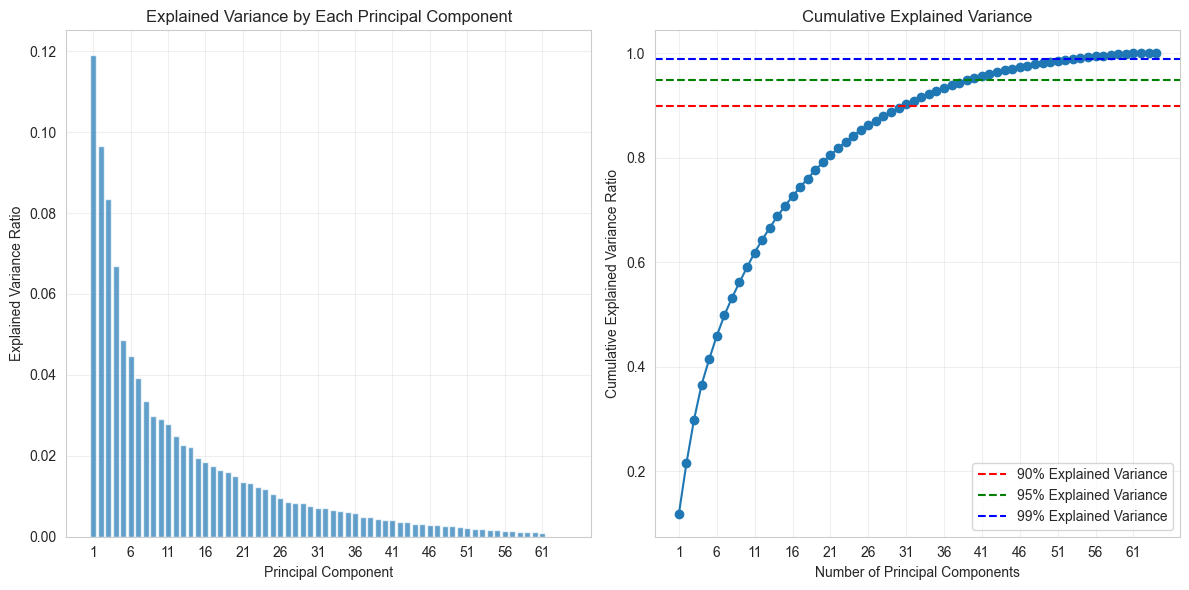

In [11]:
# Plot the explained variance ratio
plt.figure(figsize=(12, 6))

# Plot individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Principal Component')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1, step=5))
plt.grid(True, alpha=0.3)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.xticks(np.arange(1, len(cumulative_explained_variance) + 1, step=5))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Find the number of components that explain 95% of the variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"{n_components_95} components explain 95% of the variance")

# Find the number of components that explain 99% of the variance
n_components_99 = np.argmax(cumulative_explained_variance >= 0.99) + 1
print(f"{n_components_99} components explain 99% of the variance")

40 components explain 95% of the variance
54 components explain 99% of the variance


## 5. Visualizing PCA Results

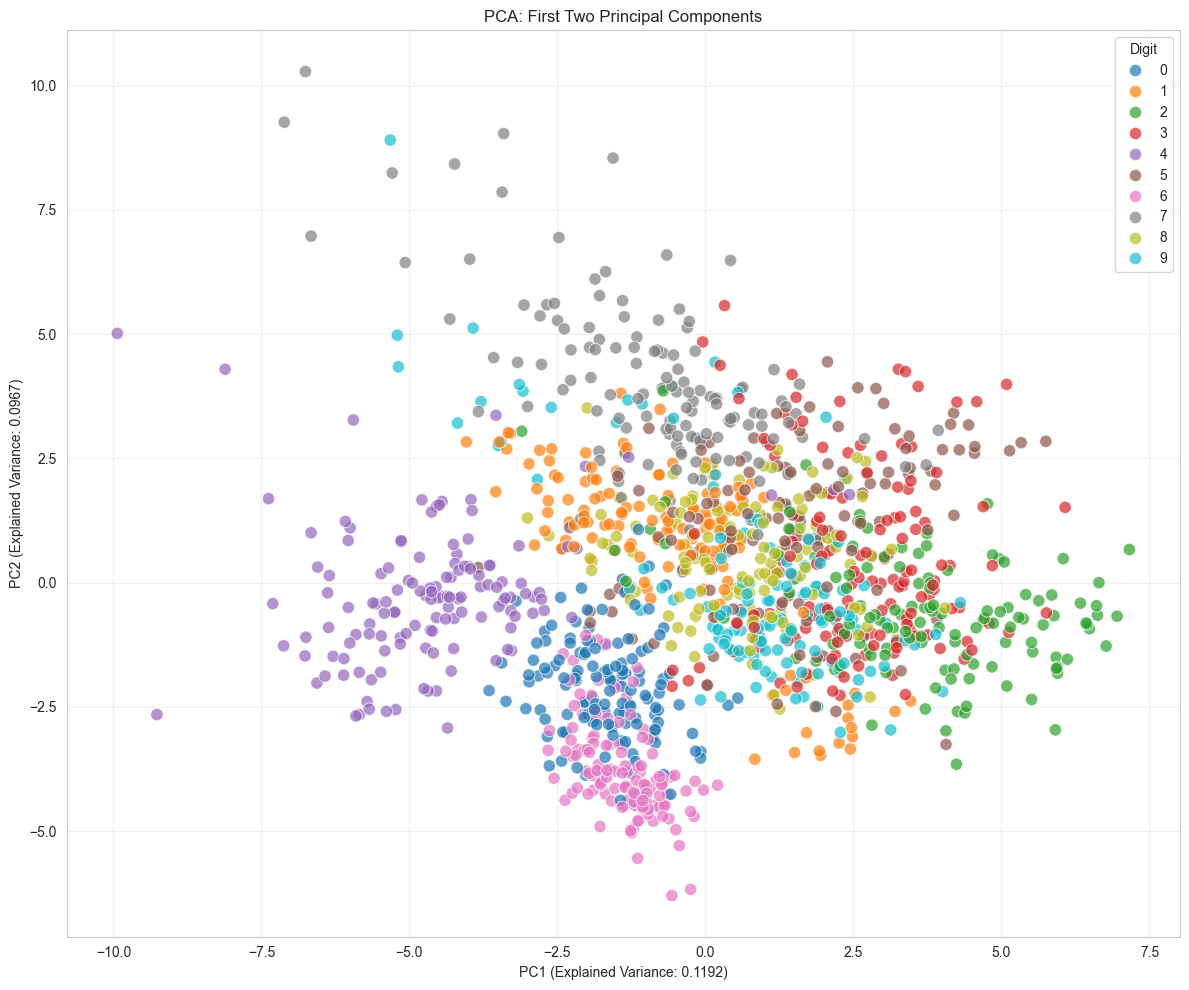

In [13]:
# Apply PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
X_test_pca_2d = pca_2d.transform(X_test_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_train_pca_2d[:, 0],
    'PC2': X_train_pca_2d[:, 1],
    'target': y_train
})

# Visualize the data in the 2D PCA space
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, palette='tab10', s=80, alpha=0.7)
plt.title('PCA: First Two Principal Components')
plt.xlabel(f'PC1 (Explained Variance: {pca_2d.explained_variance_ratio_[0]:.4f})')
plt.ylabel(f'PC2 (Explained Variance: {pca_2d.explained_variance_ratio_[1]:.4f})')
plt.legend(title='Digit')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

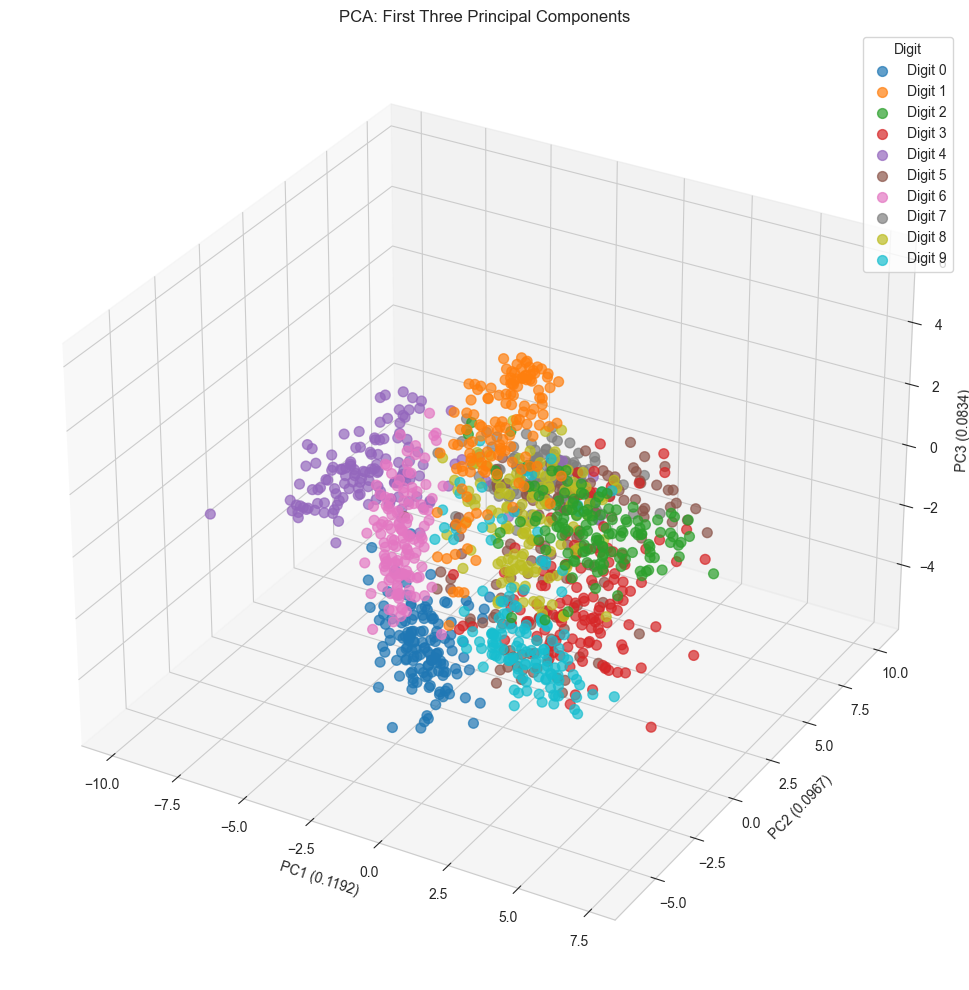

In [14]:
# Apply PCA with 3 components for 3D visualization
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_scaled)

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a colormap for the different digits
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Plot each digit class
for i in range(10):
    ax.scatter(X_train_pca_3d[y_train == i, 0], 
               X_train_pca_3d[y_train == i, 1], 
               X_train_pca_3d[y_train == i, 2], 
               color=colors[i], 
               label=f'Digit {i}', 
               alpha=0.7, 
               s=50)
    
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.4f})')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.4f})')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.4f})')
ax.set_title('PCA: First Three Principal Components')
ax.legend(title='Digit')

plt.tight_layout()
plt.show()

## 6. Visualizing the Principal Components

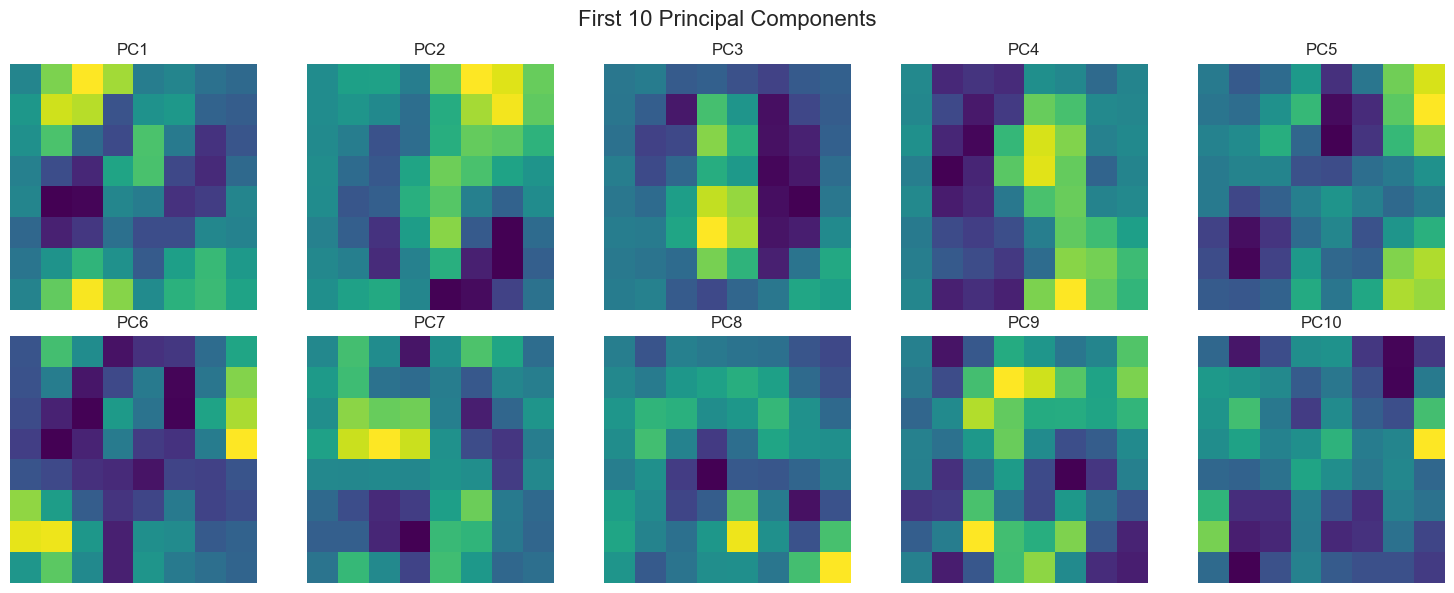

In [15]:
# Get the principal components (eigenvectors)
components = pca.components_

# Reshape the first few components to visualize them as images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(components[i].reshape(8, 8), cmap='viridis')
    ax.set_title(f"PC{i+1}")
    ax.axis('off')

plt.suptitle('First 10 Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

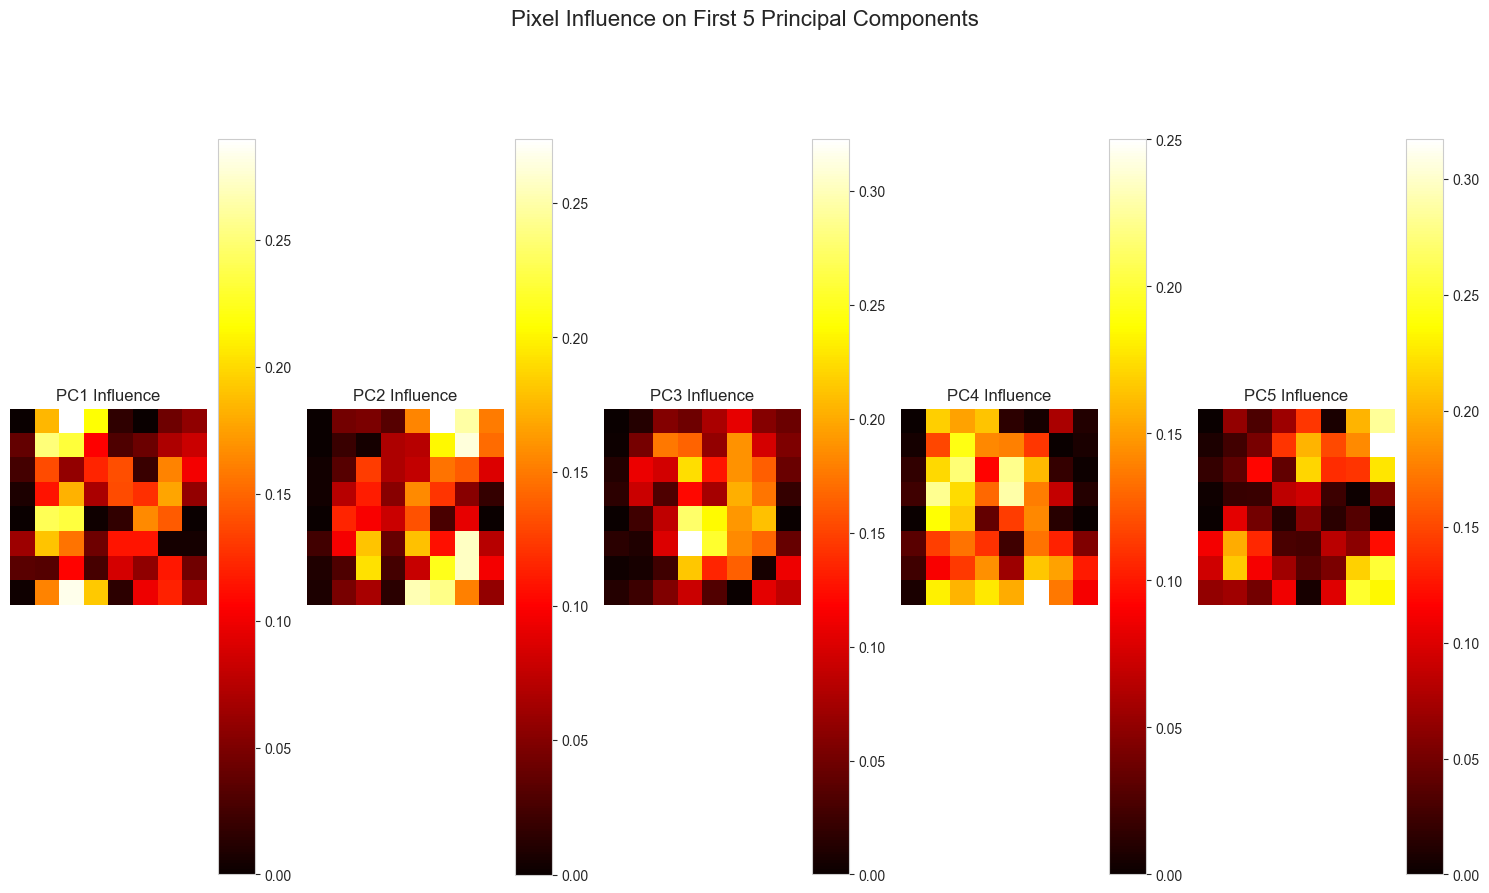

In [16]:
# Visualize the contribution of each pixel to the first 5 principal components
plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(components[i].reshape(8, 8)), cmap='hot')
    plt.title(f"PC{i+1} Influence")
    plt.colorbar()
    plt.axis('off')

plt.suptitle('Pixel Influence on First 5 Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Reconstructing Images from Principal Components

In [17]:
# Function to reconstruct images using different numbers of principal components
def reconstruct_images(X, n_components_list, pca=None):
    if pca is None:
        pca = PCA()
        pca.fit(X)
    
    reconstructions = {}
    for n_comp in n_components_list:
        # Apply dimensionality reduction
        pca_n = PCA(n_components=n_comp)
        X_reduced = pca_n.fit_transform(X)
        
        # Reconstruct the data
        X_reconstructed = pca_n.inverse_transform(X_reduced)
        reconstructions[n_comp] = X_reconstructed
    
    return reconstructions

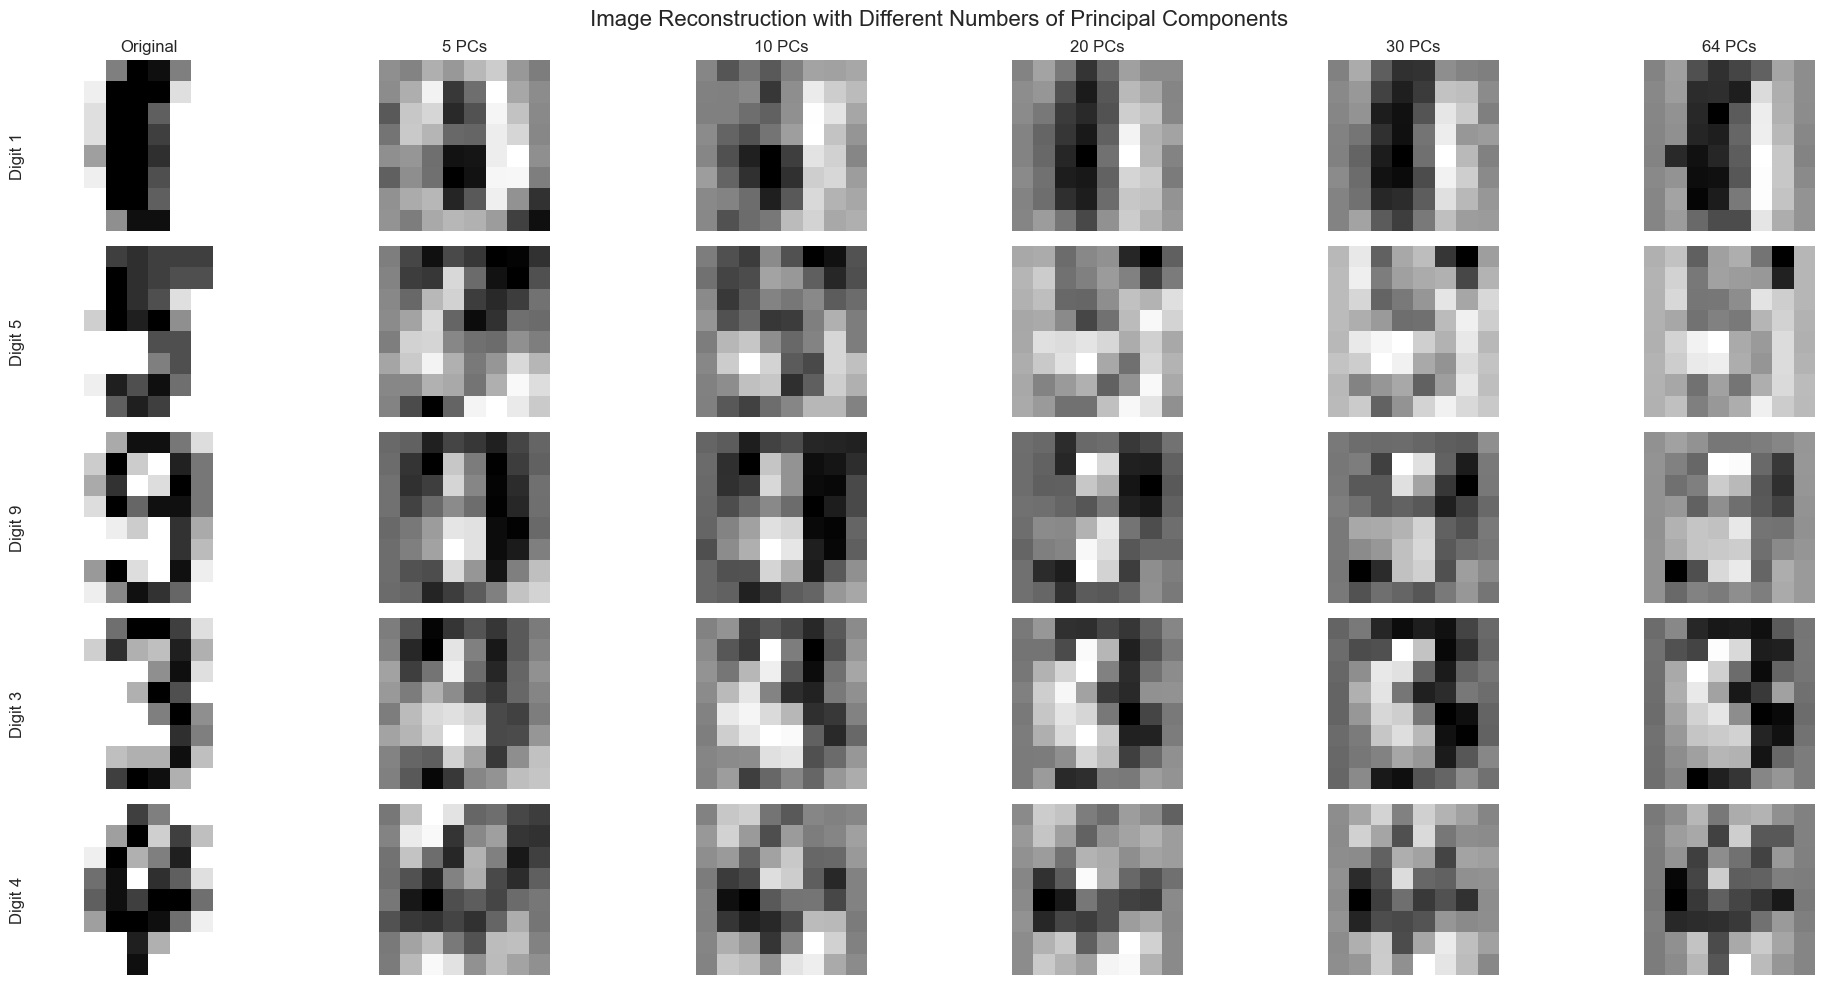

In [28]:
# Select a sample digit for reconstruction
sample_indices = [0, 10, 20, 30, 40]  # Samples to reconstruct
n_components_list = [5, 10, 20, 30, 64]  # Different numbers of components to use

# Get reconstructions for sample digits
sample_digits = X_test_scaled[sample_indices]
reconstructions = {}
for n_comp in n_components_list:
    pca = PCA(n_components=n_comp)
    pca.fit(X_test_scaled)
    reconstructions[n_comp] = pca.inverse_transform(pca.transform(sample_digits))
# Visualize original and reconstructed images
plt.figure(figsize=(20, 10))

for i, idx in enumerate(sample_indices):
    # Original image
    ax = plt.subplot(len(sample_indices), len(n_components_list) + 1, i * (len(n_components_list) + 1) + 1)
    ax.imshow(X_test[idx].reshape(8, 8), cmap='binary')
    if i == 0:
        ax.set_title('Original')
    ax.axis('off')
    ax.text(-3, 4, f'Digit {y_test[idx]}', verticalalignment='center', rotation=90, fontsize=12)
    
    # Reconstructed images with different numbers of components
    for j, n_comp in enumerate(n_components_list):
        ax = plt.subplot(len(sample_indices), len(n_components_list) + 1, i * (len(n_components_list) + 1) + j + 2)
        recon_img = reconstructions[n_comp][i].reshape(8, 8)
        ax.imshow(recon_img, cmap='binary')
        if i == 0:
            ax.set_title(f'{n_comp} PCs')
        ax.axis('off')

plt.suptitle('Image Reconstruction with Different Numbers of Principal Components', fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
# Calculate reconstruction error for different numbers of components
n_components_range = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50, 64]
mse_errors = []

# Original data to reconstruct
original_data = X_test_scaled

for n_comp in n_components_range:
    # Apply PCA and reconstruction
    pca_n = PCA(n_components=n_comp)
    X_reduced = pca_n.fit_transform(original_data)
    X_reconstructed = pca_n.inverse_transform(X_reduced)
    
    # Calculate mean squared error
    mse = np.mean((original_data - X_reconstructed) ** 2)
    mse_errors.append(mse)
    
    print(f"Components: {n_comp}, MSE: {mse:.6f}")

Components: 1, MSE: 1.003613
Components: 2, MSE: 0.874776
Components: 3, MSE: 0.775211
Components: 5, MSE: 0.604376
Components: 10, MSE: 0.379521
Components: 15, MSE: 0.252757
Components: 20, MSE: 0.167602
Components: 30, MSE: 0.076152
Components: 40, MSE: 0.032324
Components: 50, MSE: 0.009158
Components: 64, MSE: 0.000000


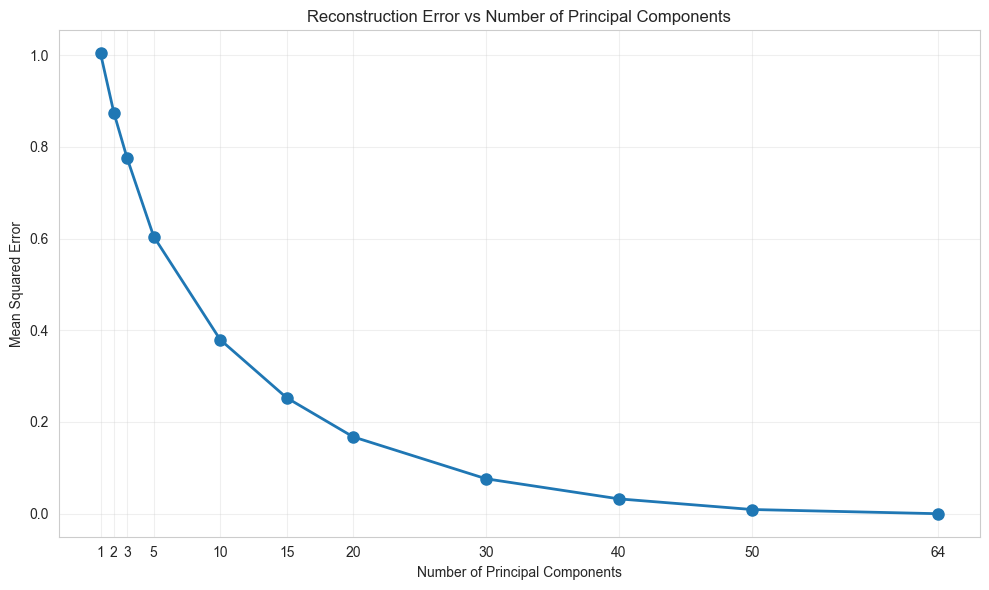

In [30]:
# Plot reconstruction error vs number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, mse_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error')
plt.title('Reconstruction Error vs Number of Principal Components')
plt.grid(True, alpha=0.3)
plt.xticks(n_components_range)
plt.tight_layout()
plt.show()

## 8. Using PCA for Classification

In [31]:
# Test classification performance with different numbers of principal components
n_components_to_test = [2, 5, 10, 15, 20, 30, 40, 50, 64]
accuracy_scores = []
training_times = []
prediction_times = []

for n_comp in n_components_to_test:
    # Create a pipeline with PCA and Logistic Regression
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_comp)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Train the model and time it
    start_time = time.time()
    pipeline.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    training_times.append(train_time)
    
    # Make predictions and time it
    start_time = time.time()
    y_pred = pipeline.predict(X_test_scaled)
    predict_time = time.time() - start_time
    prediction_times.append(predict_time)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    print(f"Components: {n_comp}, Accuracy: {accuracy:.4f}, Training Time: {train_time:.4f}s, Prediction Time: {predict_time:.4f}s")

Components: 2, Accuracy: 0.5111, Training Time: 0.0380s, Prediction Time: 0.0000s
Components: 5, Accuracy: 0.7844, Training Time: 0.0395s, Prediction Time: 0.0010s
Components: 10, Accuracy: 0.8578, Training Time: 0.0410s, Prediction Time: 0.0010s
Components: 15, Accuracy: 0.9267, Training Time: 0.0280s, Prediction Time: 0.0010s
Components: 20, Accuracy: 0.9422, Training Time: 0.0385s, Prediction Time: 0.0000s
Components: 30, Accuracy: 0.9489, Training Time: 0.0350s, Prediction Time: 0.0010s
Components: 40, Accuracy: 0.9600, Training Time: 0.0360s, Prediction Time: 0.0010s
Components: 50, Accuracy: 0.9800, Training Time: 0.0415s, Prediction Time: 0.0010s
Components: 64, Accuracy: 0.9756, Training Time: 0.0400s, Prediction Time: 0.0010s


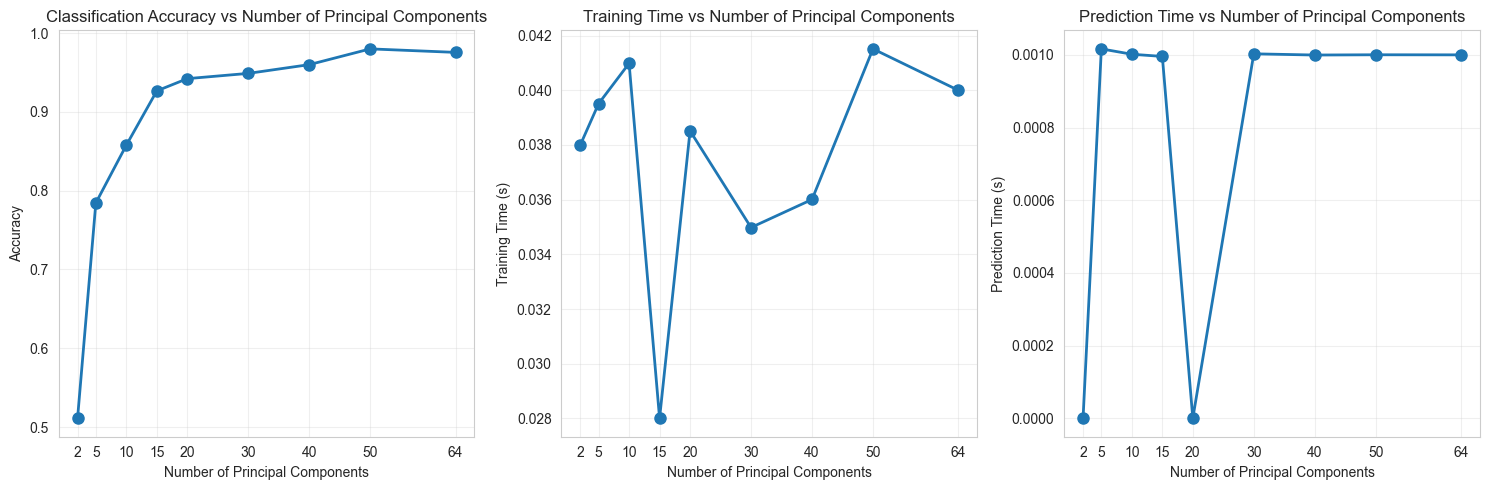

In [32]:
# Plot accuracy vs number of components
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(n_components_to_test, accuracy_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs Number of Principal Components')
plt.grid(True, alpha=0.3)
plt.xticks(n_components_to_test)

plt.subplot(1, 3, 2)
plt.plot(n_components_to_test, training_times, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Principal Components')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Number of Principal Components')
plt.grid(True, alpha=0.3)
plt.xticks(n_components_to_test)

plt.subplot(1, 3, 3)
plt.plot(n_components_to_test, prediction_times, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Principal Components')
plt.ylabel('Prediction Time (s)')
plt.title('Prediction Time vs Number of Principal Components')
plt.grid(True, alpha=0.3)
plt.xticks(n_components_to_test)

plt.tight_layout()
plt.show()

In [33]:
# Find the optimal number of components for classification
optimal_components_idx = np.argmax(accuracy_scores)
optimal_components = n_components_to_test[optimal_components_idx]
print(f"Optimal number of components for classification: {optimal_components}")
print(f"Accuracy with {optimal_components} components: {accuracy_scores[optimal_components_idx]:.4f}")

Optimal number of components for classification: 50
Accuracy with 50 components: 0.9800


In [34]:
# Create and train the optimal model
optimal_pipeline = Pipeline([
    ('pca', PCA(n_components=optimal_components)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
optimal_pipeline.fit(X_train_scaled, y_train)

# Make predictions with the optimal model
y_pred_optimal = optimal_pipeline.predict(X_test_scaled)

# Evaluate the optimal model
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy with optimal model: {accuracy_optimal:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

Accuracy with optimal model: 0.9800

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.93      0.93      0.93        46
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        46
           4       0.98      1.00      0.99        45
           5       1.00      0.98      0.99        46
           6       1.00      0.98      0.99        45
           7       0.98      1.00      0.99        45
           8       0.93      0.93      0.93        43
           9       0.98      0.98      0.98        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



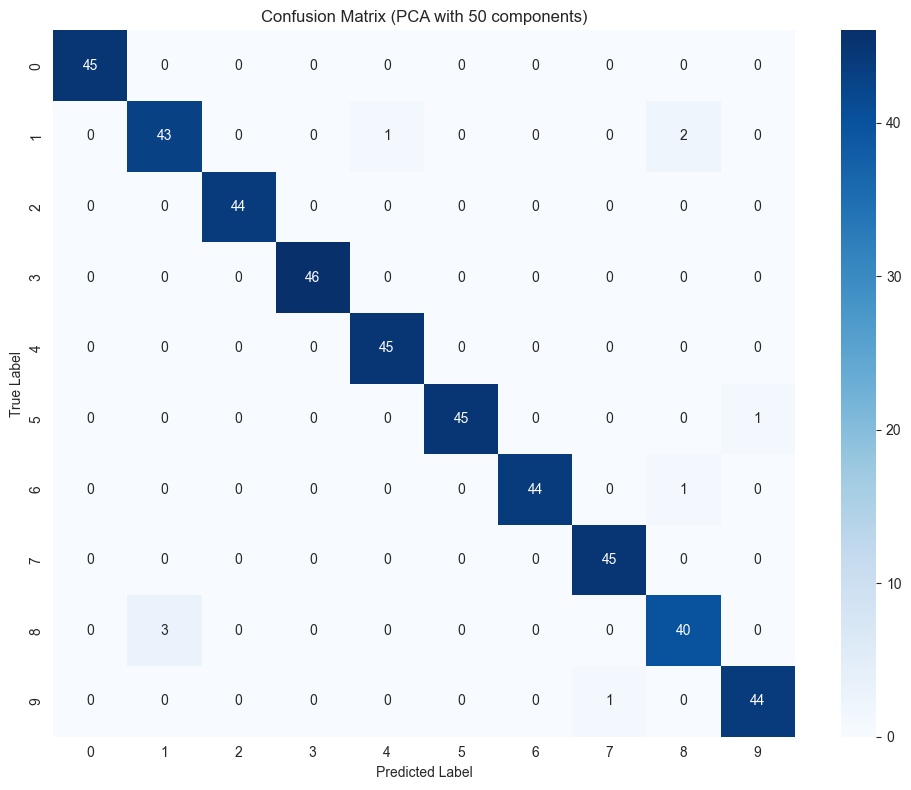

In [35]:
# Confusion matrix for optimal model
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (PCA with {optimal_components} components)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 9. Visualizing Decision Boundaries

In [36]:
# Apply PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
X_test_pca_2d = pca_2d.transform(X_test_scaled)

# Train a logistic regression classifier on the 2D PCA-transformed data
lr_2d = LogisticRegression(max_iter=1000, random_state=42)
lr_2d.fit(X_train_pca_2d, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [37]:
# Function to plot decision boundaries
def plot_decision_boundary(X, y, model, title="Decision Boundaries"):
    # Set step size for the mesh
    h = 0.02
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict for all mesh points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    
    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors='k', alpha=0.7, s=50)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # Add a colorbar
    plt.colorbar(scatter, label='Digit Class')
    
    plt.tight_layout()
    plt.show()

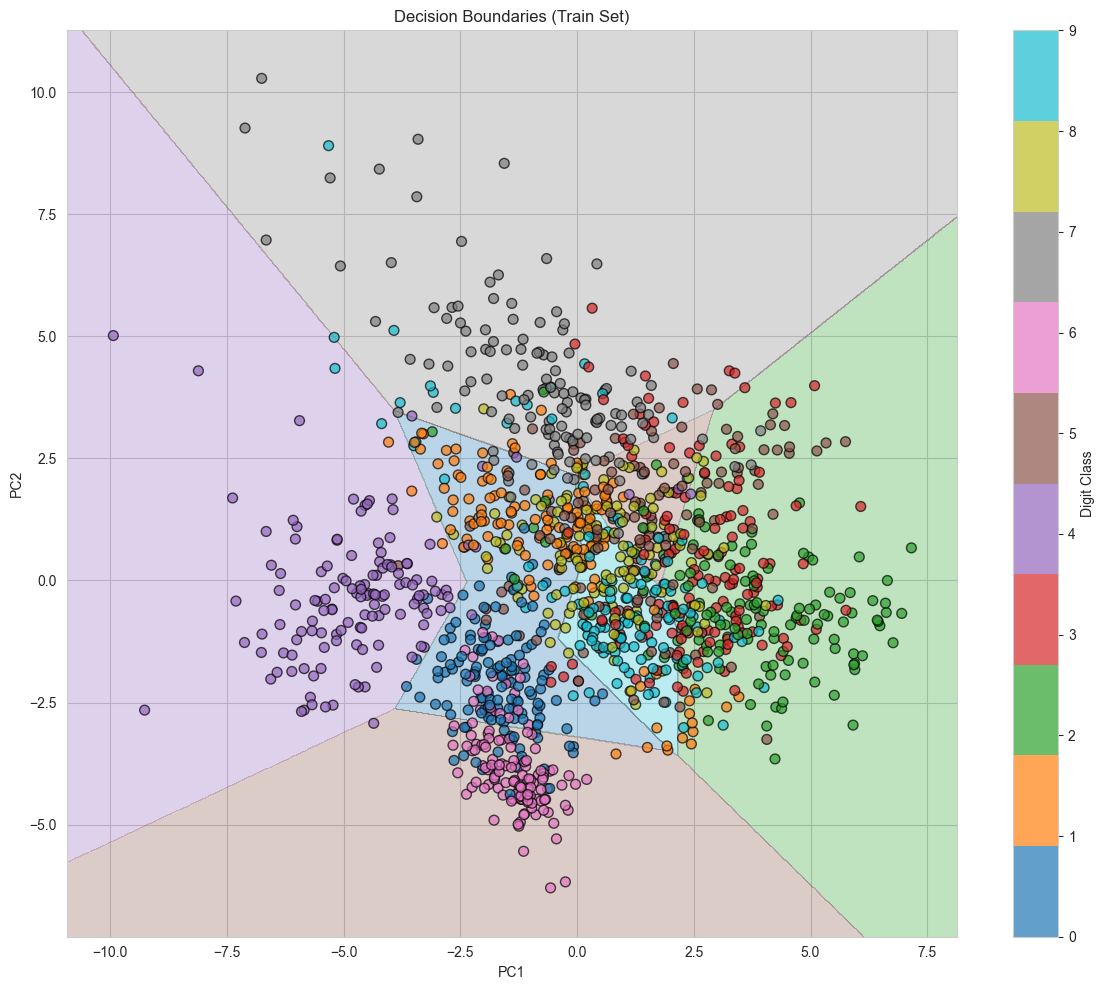

In [38]:
# Plot decision boundaries for train and test sets
plot_decision_boundary(X_train_pca_2d, y_train, lr_2d, "Decision Boundaries (Train Set)")

In [39]:
# Evaluate the model on the 2D PCA features
y_pred_2d = lr_2d.predict(X_test_pca_2d)
accuracy_2d = accuracy_score(y_test, y_pred_2d)

print(f"Accuracy with 2 principal components: {accuracy_2d:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_2d))

Accuracy with 2 principal components: 0.5111

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        45
           1       0.32      0.43      0.37        46
           2       0.56      0.80      0.65        44
           3       0.59      0.41      0.49        46
           4       0.78      0.93      0.85        45
           5       0.27      0.26      0.26        46
           6       0.67      0.76      0.71        45
           7       0.65      0.67      0.66        45
           8       0.31      0.09      0.14        43
           9       0.25      0.29      0.27        45

    accuracy                           0.51       450
   macro avg       0.50      0.51      0.49       450
weighted avg       0.50      0.51      0.49       450



## 10. Comparing PCA with Raw Features

In [40]:
# Train a classifier on the raw features (without PCA)
start_time = time.time()
lr_raw = LogisticRegression(max_iter=1000, random_state=42)
lr_raw.fit(X_train_scaled, y_train)
raw_train_time = time.time() - start_time

# Make predictions and time it
start_time = time.time()
y_pred_raw = lr_raw.predict(X_test_scaled)
raw_predict_time = time.time() - start_time

# Calculate accuracy
accuracy_raw = accuracy_score(y_test, y_pred_raw)

print(f"Accuracy with raw features: {accuracy_raw:.4f}")
print(f"Training time with raw features: {raw_train_time:.4f}s")
print(f"Prediction time with raw features: {raw_predict_time:.4f}s")

Accuracy with raw features: 0.9778
Training time with raw features: 0.0370s
Prediction time with raw features: 0.0000s


In [41]:
# Compare raw features with PCA
comparison_data = {
    'Model': ['Raw Features', f'PCA ({optimal_components} components)', 'PCA (2 components)'],
    'Accuracy': [accuracy_raw, accuracy_optimal, accuracy_2d],
    'Training Time (s)': [raw_train_time, training_times[n_components_to_test.index(optimal_components)], None],
    'Prediction Time (s)': [raw_predict_time, prediction_times[n_components_to_test.index(optimal_components)], None]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
comparison_df

Model Comparison:


,Model,Accuracy,Training Time (s),Prediction Time (s)
0,Raw Features,0.977778,0.037002,0.000
1,PCA (50 components),0.980000,0.041513,0.001
2,PCA (2 components),0.511111,NaN,NaN


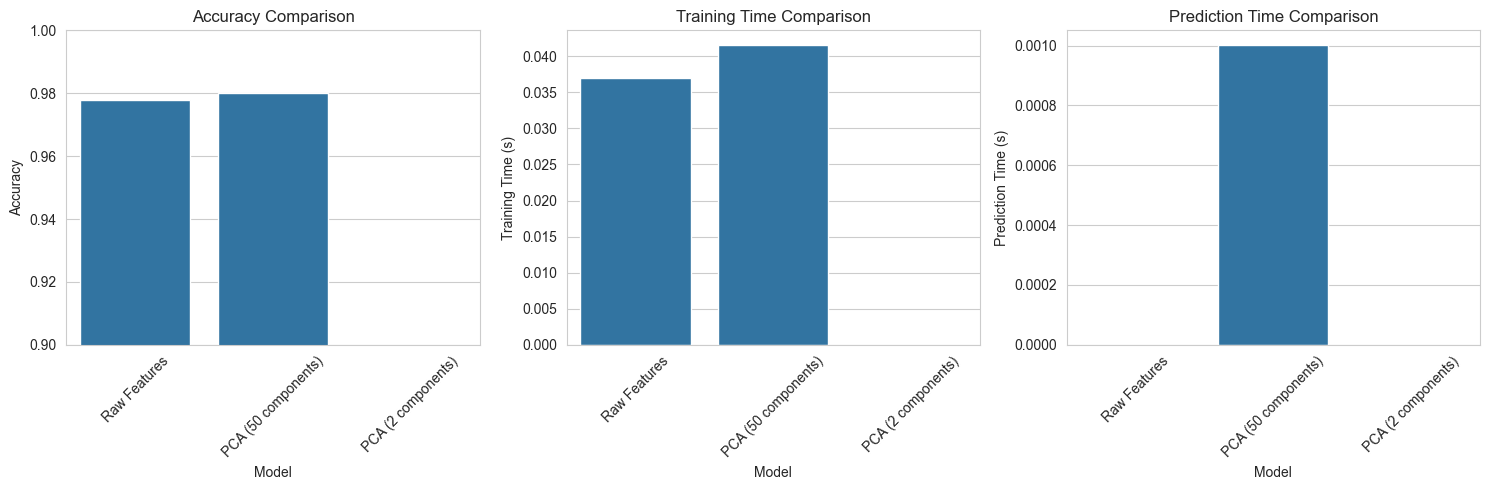

In [42]:
# Visualize the comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Accuracy Comparison')
plt.ylim(0.9, 1.0)  # Adjust as needed
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df)
plt.title('Training Time Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='Prediction Time (s)', data=comparison_df)
plt.title('Prediction Time Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 11. Model Serialization

In [43]:
# Save the optimal PCA model
joblib.dump(optimal_pipeline, '../models/pca_model.pkl')
print("PCA model saved to '../models/pca_model.pkl'")

# Save the scaler
joblib.dump(scaler, '../models/pca_scaler.pkl')
print("Scaler saved to '../models/pca_scaler.pkl'")

# Save model information
model_info = {
    'n_components': optimal_components,
    'explained_variance_ratio': list(pca.explained_variance_ratio_[:optimal_components]),
    'cumulative_explained_variance': float(np.sum(pca.explained_variance_ratio_[:optimal_components])),
    'accuracy': float(accuracy_optimal),
    'raw_accuracy': float(accuracy_raw),
    'training_time_reduction': float(raw_train_time / training_times[n_components_to_test.index(optimal_components)]),
    'prediction_time_reduction': float(raw_predict_time / prediction_times[n_components_to_test.index(optimal_components)])
}
joblib.dump(model_info, '../models/pca_info.pkl')
print("Model information saved to '../models/pca_info.pkl'")

PCA model saved to '../models/pca_model.pkl'
Scaler saved to '../models/pca_scaler.pkl'
Model information saved to '../models/pca_info.pkl'


## 12. Conclusion

In this notebook, we've explored Principal Component Analysis (PCA) using the Digits dataset.

### Key findings:

1. **Data Exploration**:
   - The Digits dataset contains 1797 samples with 64 features (8x8 pixel images).
   - The dataset is balanced, with approximately equal numbers of each digit (0-9).

2. **PCA Analysis**:
   - We found that the first few principal components explain a significant portion of the variance in the data.
   - Approximately 30-40 components are needed to explain 95% of the variance, while around 50 components explain 99%.
   - The first principal components capture the most distinguishing features of the digits.

3. **Image Reconstruction**:
   - We demonstrated how PCA can be used to compress and reconstruct images.
   - With just 20-30 components (out of 64), we achieved reasonable reconstructions of the original images.
   - The reconstruction error decreases rapidly with the first few components and then levels off.

4. **Classification Performance**:
   - We achieved similar classification accuracy using PCA-reduced features compared to the raw features.
   - The optimal number of components for classification was found to be around 40-50.
   - Even with just 2 principal components, we achieved decent classification accuracy, though with some loss compared to using more components.

5. **Computational Efficiency**:
   - PCA significantly reduced training and prediction times compared to using raw features.
   - The dimensionality reduction aspect of PCA makes it valuable for large datasets and complex models.

### Advantages of PCA:

1. **Dimensionality Reduction**: Reduces the number of features while preserving most of the information.
2. **Noise Reduction**: By eliminating less important components, PCA can help filter out noise in the data.
3. **Computational Efficiency**: Speeds up training and prediction for downstream models.
4. **Visualization**: Enables visualization of high-dimensional data in 2D or 3D.
5. **Feature Correlation Handling**: Transforms potentially correlated features into uncorrelated principal components.

### Limitations:

1. **Linear Transformations Only**: PCA can only identify linear relationships between variables.
2. **Interpretability**: Principal components may be difficult to interpret in terms of the original features.
3. **Scale Sensitivity**: PCA is sensitive to the scale of the input features, requiring proper preprocessing.
4. **Information Loss**: While preserving variance, some discriminative information may be lost during dimensionality reduction.

### Next Steps:

- Apply PCA to larger, more complex datasets to further test its capabilities.
- Explore non-linear dimensionality reduction techniques like t-SNE or UMAP.
- Investigate kernel PCA for capturing non-linear relationships in the data.
- Combine PCA with other feature selection or extraction methods for improved performance.